In [1]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem
import os
import pandas as pd
import argparse
import pickle
import os
import sys
import torch
import rdkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import json
import pickle
from sklearn.model_selection import train_test_split

In [2]:
%run /Users/vxjdk@leo-pharma.com/mol_utils

In [3]:
datasets = ["Homopiperazines","Piperazines","Piperidines","Sulphamides"]
names = ["JAK1 EC50 nM 1027","JAK2 EC50 nM 1024","JAK3 EC50 nM 1026"]
names = names + ['TYK2 EC50 nM 1025']
files = ["/dbfs/FileStore/tables/Homopiperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperidines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Sulphamides_cleaned_Feb_2019.sdf",
        ]
PARENT_DIR = '/dbfs/FileStore/tables'
PICKLES_DIR = '/dbfs/FileStore/pickles'
MOSES_DIR = '/dbfs/FileStore/moses'
CHEMPROP_DIR = '/dbfs/FileStore/chemprop'

ZINC_DIR = '/dbfs/FileStore/ZINC'
ZINC_Models = os.path.join(ZINC_DIR,'models')
VIRTUAL_SCREENING = os.path.join(ZINC_DIR,'virtual_screening')
targets=['JAK1','JAK2','JAK3','TYK2']

G2G = '/dbfs/FileStore/g2g'
TENSORS = os.path.join(G2G,'tensors')
dest = 'median-train_pairs'
datasets = ['dpEC1-all_pairs-JAK1.txt', 
            'dpEC1-all_pairs-JAK2.txt', 
            'dpEC1-all_pairs-JAK3.txt', 
            'dpEC1-all_pairs-TYK2.txt', 
            'dpEC1-close_pairs-JAK1.txt', 
            'dpEC1-close_pairs-JAK2.txt', 
            'dpEC1-close_pairs-JAK3.txt', 
            'dpEC1-close_pairs-TYK2.txt', 
            'dpEC1to2-all_pairs-JAK1.txt', 
            'dpEC1to2-all_pairs-JAK2.txt', 
            'dpEC1to2-all_pairs-JAK3.txt', 
            'dpEC1to2-all_pairs-TYK2.txt', 
            'dpEC1to2-close_pairs-JAK1.txt', 
            'dpEC1to2-close_pairs-JAK2.txt', 
            'dpEC1to2-close_pairs-JAK3.txt', 
            'dpEC1to2-close_pairs-TYK2.txt', 
            'median-all_pairs-JAK1.txt', 
            'median-all_pairs-JAK2.txt', 
            'median-all_pairs-JAK3.txt', 
            'median-all_pairs-TYK2.txt', 
            'median-close_pairs-JAK1.txt', 
            'median-close_pairs-JAK2.txt', 
            'median-close_pairs-JAK3.txt', 
            'median-close_pairs-TYK2.txt', 
            'pEC7.6-all_pairs-JAK1.txt', 
            'pEC7.6-all_pairs-JAK2.txt', 
            'pEC7.6-all_pairs-JAK3.txt', 
            'pEC7.6-all_pairs-TYK2.txt', 
            'pEC7.6-close_pairs-JAK1.txt', 
            'pEC7.6-close_pairs-JAK2.txt', 
            'pEC7.6-close_pairs-JAK3.txt', 
            'pEC7.6-close_pairs-TYK2.txt']

In [4]:

from chemprop.parsing import parse_predict_args
from chemprop.train import make_predictions
from chemprop.parsing import add_predict_args
from chemprop.parsing import modify_predict_args
valid_file = os.path.join(G2G, 'validation_set-all_targets.smi')
datasets = [#'dpEC1-all_pairs-JAK1.txt',
            #'dpEC1-close_pairs-JAK1.txt',
#             'dpEC1to2-all_pairs-JAK1.txt',
            'dpEC1to2-close_pairs-JAK1.txt',
            'dpEC1to2-close_pairs-TYK2.txt'#,
#             'median-all_pairs-JAK1.txt',
#             'median-close_pairs-JAK1.txt',
#             'pEC7.6-all_pairs-JAK1.txt',
#             'pEC7.6-close_pairs-JAK1.txt'
           ]
#datasets = ['dpEC1-all_pairs-JAK1-default','dpEC1-all_pairs-JAK1-hopt-2e']
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from copy import deepcopy
n_actives = '-all_inactives'
ITERATIONS = 10
#epochs = ['20','10']
n_samples = '10000'
targets =['JAK1', 'TYK2']#['JAK1','JAK2','JAK3','TYK2']
VS_Models = os.path.join(VIRTUAL_SCREENING,'models')
coords_all = []
cols_all=[]
all_mols=[]
all_true_mols = []
all_sizes = []
nonjaks = []
targets = ['JAK1','TYK2']
reals_jak2 = []
batches_actives = []
batches_inactives = []
for j,dataset in enumerate(datasets):
    all_actives = None
    all_inactives = None

    sizes = []
    batch = []
    inbatch = []
    for i in range(ITERATIONS):
      inactives = pd.read_csv(os.path.join(G2G,'models','10e-'+dataset[:-4],'VS-iter-'+str(i)+'-inactives'+n_actives+'.csv'))
      actives = pd.read_csv(os.path.join(G2G,'models','10e-'+dataset[:-4],'VS-iter-'+str(i)+'-actives'+n_actives+'.csv'))#pd.read_csv(os.path.join(G2G,'models','10e-'+dataset[:-4],'VS-iter-'+str(i)+'-actives.csv'))
      if all_inactives is not None:
        all_inactives = all_inactives.append(inactives).drop_duplicates()
      else:
        all_inactives = deepcopy(inactives).drop_duplicates()
      #print(inactives.head())
      if all_actives is not None:
        all_actives = all_actives.append(actives).drop_duplicates()  
      else:
        all_actives = deepcopy(actives).drop_duplicates()
      sizes.append(len(all_actives))
      print('All active molecules:',len(all_actives))
      print('Active molecules this round:',len(actives))
      print('Inactive molecules:',len(all_inactives))
      print(os.path.join(G2G,'models','10e-'+dataset[:-4],'VS-iter-'+str(i)+'-actives'+n_actives+'.csv'))
      batch.append(len(all_actives))
      inbatch.append(len(all_inactives))
    batches_actives.append(batch)
    batches_inactives.append(inbatch)
    
    test_path = os.path.join(G2G,'models','10e-'+dataset[:-4],'VS-total-actives'+n_actives+'.csv')
    all_actives.to_csv(test_path,index=False)
    all_actives['Molecule'] = [Chem.MolFromSmiles(smi) for smi in all_actives.smiles]
    pred_parser = ArgumentParser()
    add_predict_args(pred_parser)
    checkpoint_path = os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/model.pt')
    test_path = os.path.join(G2G,'models','10e-'+dataset[:-4],'VS-total-actives'+n_actives+'.csv')
    preds_path_classification = os.path.join(G2G,'models','10e-'+dataset[:-4],'VS-total-actives'+n_actives+'-classification.csv')

    args = pred_parser.parse_args(['--test_path',test_path,
                                   '--checkpoint_path',checkpoint_path,
                                   #'--checkpoint_dir',checkpoint_dir,
                                   '--preds_path',preds_path_classification,
                                   #'--features_path',features_path,
                                  ])
    modify_predict_args(args)
    #make_predictions(args)

    #frame = pd.read_csv(preds_path_classification)#.dropna(subset=targets)
    nonjak2 = pd.read_csv(preds_path_classification)
    nonjak2 = all_actives[nonjak2['JAK2']<0.05]
    nonjak2['Molecule'] = [Chem.MolFromSmiles(smi) for smi in nonjak2.smiles]
    nonjak2['canonsmiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),canonical=True,isomericSmiles=False) for smi in nonjak2.smiles]
    all_trues = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all_2188-sparse-regression.csv'))
    all_trues.smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi.split('.')[0]),canonical=True,isomericSmiles=False) for smi in all_trues.smiles]
    true_actives = all_trues[all_trues[targets[j]]>7.6]
    all_trues['Molecule'] = [Chem.MolFromSmiles(smi) for smi in all_trues.smiles]
    nonjak2 = nonjak2[~nonjak2.canonsmiles.isin(all_trues.smiles.tolist())]
    
    
    real_jak2 = [Chem.MolFromSmiles(smi) for smi in true_actives[true_actives['JAK2']>7.6].smiles]
    true_mols =[Chem.MolFromSmiles(smi) for smi in true_actives.smiles]
    print(len(nonjak2))
    col = np.array(nonjak2[targets[j]].tolist())
    #true_mols = [Chem.MolFromSmiles(smi) for smi in train_mols]
    mols = all_actives['Molecule'].tolist()
    #fps = get_fps(mols+true_mols+nonjak2['Molecule'].tolist(), bit=True)
    fps = get_fps(list(mols)+true_mols+real_jak2+nonjak2['Molecule'].tolist(), bit=True)
    dists = fps_distances(fps)
    coords = get_embedding('tsne', 2, dists)
    coords_all.append(coords)
    all_mols.append(mols)
    all_true_mols.append(true_mols)
    cols_all.append(col)
    all_sizes.append(sizes)
    nonjaks.append(nonjak2)
    reals_jak2.append(real_jak2)

All active molecules: 590
Active molecules this round: 590
Inactive molecules: 84
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-JAK1/VS-iter-0-actives-all_inactives.csv
All active molecules: 887
Active molecules this round: 382
Inactive molecules: 124
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-JAK1/VS-iter-1-actives-all_inactives.csv
All active molecules: 1025
Active molecules this round: 210
Inactive molecules: 146
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-JAK1/VS-iter-2-actives-all_inactives.csv
All active molecules: 1082
Active molecules this round: 140
Inactive molecules: 150
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-JAK1/VS-iter-3-actives-all_inactives.csv
All active molecules: 1115
Active molecules this round: 63
Inactive molecules: 153
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-JAK1/VS-iter-4-actives-all_inactives.csv
All active molecules: 1147
Active molecules this round: 32
Inactive molecules: 160
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-JAK1/VS-iter-5-actives-all_inactives.csv
All active molecules: 1185
Active molecules this round: 64
Inactive molecules: 161
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-JAK1/VS-iter-6-actives-all_inactives.csv
All active molecules: 1207
Active molecules this round: 22
Inactive molecules: 161
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-JAK1/VS-iter-7-actives-all_inactives.csv
All active molecules: 1215
Active molecules this round: 8
Inactive molecules: 161
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-JAK1/VS-iter-8-actives-all_inactives.csv
All active molecules: 1215
Active molecules this round: 8
Inactive molecules: 161
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-JAK1/VS-iter-9-actives-all_inactives.csv
31
Errors in conversion: 0
Selected transformation: T-SNE
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2951 samples in 0.006s...
[t-SNE] Computed neighbors for 2951 samples in 0.124s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2951
[t-SNE] Computed conditional probabilities for sample 2000 / 2951
[t-SNE] Computed conditional probabilities for sample 2951 / 2951
[t-SNE] Mean sigma: 0.268947
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.525963
[t-SNE] Error after 300 iterations: 1.158860
All active molecules: 225
Active molecules this round: 225
Inactive molecules: 584
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-TYK2/VS-iter-0-actives-all_inactives.csv
All active molecules: 370
Active molecules this round: 193
Inactive molecules: 782
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-TYK2/VS-iter-1-actives-all_inactives.csv
All active molecules: 457
Active molecules this round: 176
Inactive molecules: 972
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-TYK2/VS-iter-2-actives-all_inactives.csv
All active molecules: 529
Active molecules this round: 180
Inactive molecules: 1122
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-TYK2/VS-iter-3-actives-all_inactives.csv
All active molecules: 592
Active molecules this round: 182
Inactive molecules: 1274
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-TYK2/VS-iter-4-actives-all_inactives.csv
All active molecules: 631
Active molecules this round: 175
Inactive molecules: 1399
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-TYK2/VS-iter-5-actives-all_inactives.csv
All active molecules: 667
Active molecules this round: 176
Inactive molecules: 1515
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-TYK2/VS-iter-6-actives-all_inactives.csv
All active molecules: 718
Active molecules this round: 169
Inactive molecules: 1629
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-TYK2/VS-iter-7-actives-all_inactives.csv
All active molecules: 751
Active molecules this round: 167
Inactive molecules: 1732
/dbfs/FileStore/g2g/models/10e-dpEC1to2-close_pairs-TYK2/VS-iter-8-actives-all_inactives.csv
All active molecules: 779
Active molecules this round: 176
Inactive molecules: 1830
/dbfs/FileStore/g

In [5]:
nonjaks[1].canonsmiles.values[0]

Out[20]: 'CN(C)S(N)(=O)=O'

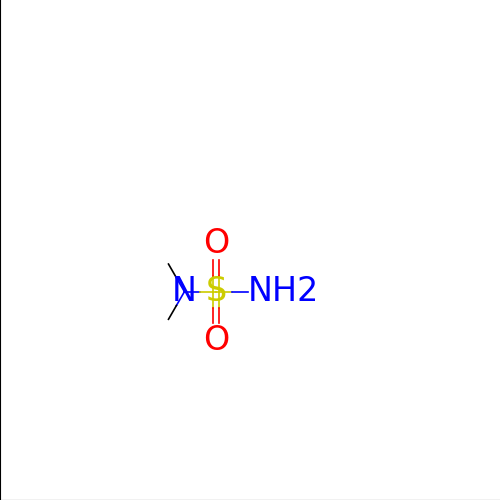

In [6]:
#Outlier
from rdkit.Chem import Draw
fig = Draw.MolToMPL(Chem.MolFromSmiles(nonjaks[1].canonsmiles.values[0]), size=(500,500))
ax = fig.axes[0]
ax.set_xlim(0,3)
ax.set_ylim(0,3)
display(fig.show())

In [7]:
# Get SMILES and SMARTS for representatives
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.AllChem import CalcNumAtomStereoCenters
def get_clustering(mols,cutoff):
  fps = get_fps(mols, bit=True,size=6)
  clusters=ClusterFps(fps, cutoff=cutoff)
  
  return clusters
cutoff = 0.6
for nonjak in nonjaks:
  mols = np.array([Chem.MolFromSmiles(smi) for smi in nonjak.smiles])
  clusters = list(get_clustering(mols,cutoff))
  print(len(clusters))
  clusters.sort(key=len,reverse=True)
  for cluster in clusters[:5]:
    cluster_mols = mols[list(cluster)]
    if len(cluster_mols)>1:
      
      mcs = FindMCS(cluster_mols, completeRingsOnly=False, ringMatchesRingOnly=False, matchValences=True, timeout=2)
      mcs = mcs.smartsString
      print(mcs)
      print(Chem.MolToSmiles(cluster_mols[0]))
      print('cluster size:',len(cluster_mols))

Errors in conversion: 0
16
[#6]-[#6]-[#7](-[#6])-[#16](=[#8])(=[#8])-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-12-[#6]-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2
CC(=O)NCC(=O)N1CCCC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
cluster size: 10
[#6]-[#6]-[#6]-[#6]-[#6]-[#8]-[#6](=[#8])-[#7]1-[#6]2-[#6]-[#6]-[#6]-1-[#6]-[#7](-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2
NS(=O)(=O)N1CCC[C@@H]1COC(=O)N1[C@H]2CC[C@@H]1CN(c1ncnc3[nH]ccc13)C2
cluster size: 5
[#6]-[#6]-[#7](-[#6]-[#6])-[#16](=[#8])(=[#8])-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-12-[#6]-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2
O=S(=O)(N(CCc1ccccc1)CCC(F)(F)F)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
cluster size: 2
[#8]=[#6](-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1):[#6]:[#6])-[#7]1-[#6]2-[#6]-[#6]-[#6]-1-[#6]-[#7](-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2
O=C(c1ccc2sccc2c1)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2
cluster size: 2
Errors in conversion: 0
1

In [8]:

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.AllChem import CalcNumAtomStereoCenters
from rdkit.DataStructs.TopNContainer import TopNContainer

def get_clustering(mols,cutoff):
  fps = get_fps(mols, bit=True,size=6)
  clusters=ClusterFps(fps, cutoff=cutoff)
  return clusters
cutoff = 0.6
real_smiles = np.array(all_trues.smiles)
for nonjak in nonjaks:
  mols = np.array([Chem.MolFromSmiles(smi) for smi in nonjak.smiles])
  clusters = list(get_clustering(mols,cutoff))
  print(len(clusters))
  clusters.sort(key=len,reverse=True)
  for cluster in clusters[:5]:
    clu_rep = mols[list(cluster)][0]
    nearest_real_id = np.argmax(np.array(DataStructs.BulkTanimotoSimilarity(FingerprintMols.FingerprintMol(clu_rep),[FingerprintMols.FingerprintMol(x) for x in all_trues['Molecule']],returnDistance=False)))
    nearest_real = real_smiles[nearest_real_id]
    print(Chem.MolToSmiles(clu_rep))
    print(nearest_real)
    

Errors in conversion: 0
16
CC(=O)NCC(=O)N1CCCC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CNCC(=O)N1CCCC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
NS(=O)(=O)N1CCC[C@@H]1COC(=O)N1[C@H]2CC[C@@H]1CN(c1ncnc3[nH]ccc13)C2
CS(=O)(=O)N1CCCC1COC(=O)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2
O=S(=O)(N(CCc1ccccc1)CCC(F)(F)F)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
CCCN(CCc1ccccc1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
O=C(c1ccc2sccc2c1)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2
O=C(c1ccc2sccc2c1)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
O=C(OCc1ccc(F)cc1F)N1[C@H]2CC[C@@H]1CN(c1ncc3[nH]ccc3n1)C2
O=C(OCc1ccc(F)cc1F)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2
Errors in conversion: 0
1
CN(C)S(N)(=O)=O
CN(CC1CC(F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2

In [9]:

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.AllChem import CalcNumAtomStereoCenters
from rdkit.DataStructs.TopNContainer import TopNContainer

def get_clu_ids(mols,cutoff):
  fps = get_fps(mols, bit=True,size=6)
  clusters=ClusterFps(fps, cutoff=cutoff)
  return clusters
cutoff = 0.6
real_smiles = np.array(all_trues.smiles)
targets = ['JAK1','TYK2']
for i, nonjak in enumerate(nonjaks):
  mols = np.array([Chem.MolFromSmiles(smi) for smi in nonjak.smiles])
  clusters = list(get_clustering(mols,cutoff))
  print(len(clusters))
  clusters.sort(key=len,reverse=True)
  for cluster in clusters[:2]:
    clu_df = nonjak.iloc[list(cluster)]
    max_row = clu_df.loc[clu_df[targets[i]].idxmax()]
    nearest_real_id = np.argmax(np.array(DataStructs.BulkTanimotoSimilarity(FingerprintMols.FingerprintMol(max_row['Molecule']),[FingerprintMols.FingerprintMol(x) for x in all_trues['Molecule']],returnDistance=False)))
    nearest_real = all_trues.iloc[nearest_real_id]#real_smiles[nearest_real_id]
    print('Best clu : ',max_row.smiles)
    print('Activity : ',max_row[targets[i]])
    print('Best real: ',nearest_real.smiles)
    print('Activity : ',nearest_real[targets[i]])
  for j, row in nonjak.nlargest(2, columns=[targets[i]]).iterrows():
    max_row = row
    nearest_real_id = np.argmax(np.array(DataStructs.BulkTanimotoSimilarity(FingerprintMols.FingerprintMol(max_row['Molecule']),[FingerprintMols.FingerprintMol(x) for x in all_trues['Molecule']],returnDistance=False)))
    nearest_real = all_trues.iloc[nearest_real_id]#real_smiles[nearest_real_id]
    print('Best mol : ',max_row.smiles)
    print('Activity : ',max_row[targets[i]])
    print('Best real: ',nearest_real.smiles)
    print('Activity : ',nearest_real[targets[i]])

    

Errors in conversion: 0
16
Best clu : CN(CC1CC(F)(F)CN1C(=O)C(=O)OCC(C)(C)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 8.38918563102646
Best real: CCOC(=O)C(=O)N1CC(F)(F)CC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 8.899629454882437
Best clu : CC1CCC(C(C)(O)COC(=O)N2C3CCC2CN(c2ncnc4[nH]ccc24)C3)CC1
Activity : 7.5345334731157125
Best real: O=C(OCC1(O)CCCC1)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2
Activity : 7.1904402853647325
Best mol : CN(CC1CC(F)(F)CN1C(=O)C(=O)OCC(C)(C)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 8.38918563102646
Best real: CCOC(=O)C(=O)N1CC(F)(F)CC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 8.899629454882437
Best mol : CC(=O)NCC(=O)N1CC(F)CC1CN(C)S(=O)(=O)N1CC(F)(F)CC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 8.343495781502272
Best real: CC(=O)NCC(=O)N1CC(F)(F)CC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 9.356547323513812
Errors in conversion: 0
1
Best clu : CN(C)S(N)(=O)=O
Activity : 7.187978916385647
Best real: CN(CC1CC(F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 6.283162276700477
Best mol : CN(C)S(N)(=O)=O
Activity : 7.187978916385647
Best real: CN(CC1CC(F)CN1S(N)(=O)=O)S(=O)(=O)N1CCCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 6.283162276700477

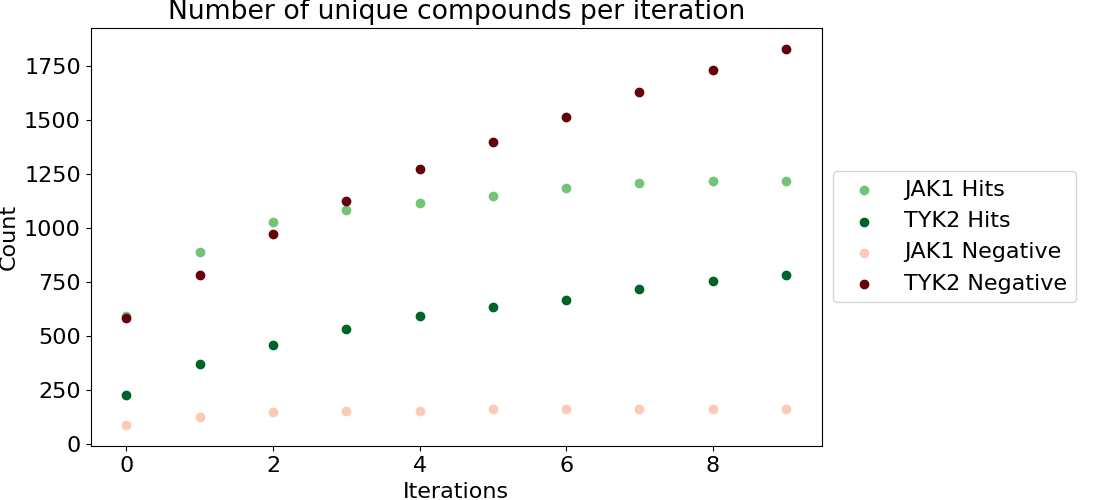

In [10]:
import matplotlib
plt.close()
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

plt.figure(figsize=(11,5))
colors = [plt.cm.Greens(np.linspace(0.5,0.9,len([batches_actives, batches_inactives]))),plt.cm.Reds(np.linspace(0.2,1,len([batches_actives, batches_inactives])))]
#ax.scatter(x, np.array(d[col][target]), color=colors[j][i],label=str(col)+': '+str(target))
for i,molset in enumerate([batches_actives, batches_inactives]):
  print(molset)
  for j,target in enumerate(molset):
    print(target)
    plt.scatter(range(10),target,color=colors[i][j],label=str([['JAK1 Hits','JAK1 Negative'],['TYK2 Hits','TYK2 Negative']][j][i]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.title('Number of unique compounds per iteration')
plt.xlabel('Iterations')
plt.ylabel('Count')
display(plt.show())

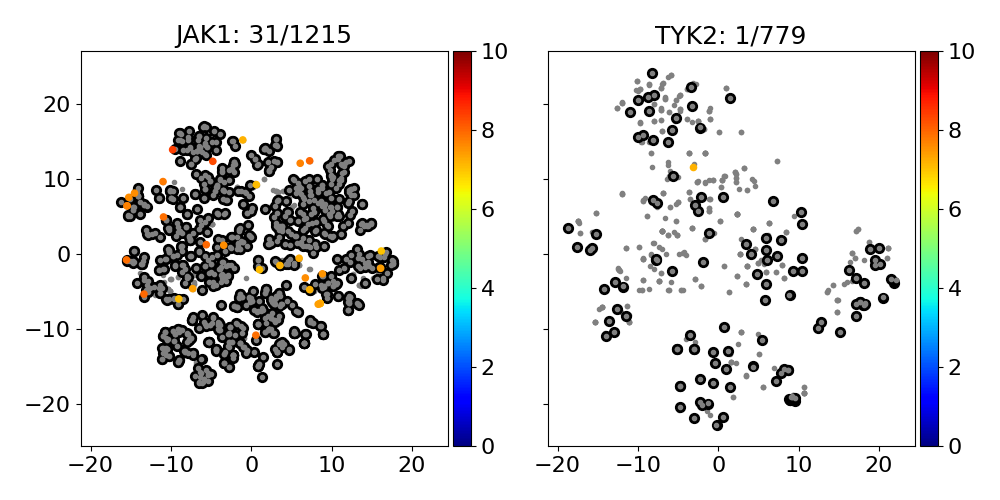

In [11]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.close()
f, axes = plt.subplots(1, 2, sharex = True, sharey=True, figsize=(10,5))

for i, name in enumerate(targets):
  
  axes[i].scatter(coords_all[i][:len(all_mols[i]), 0], 
                   coords_all[i][:len(all_mols[i]), 1], 
                   marker = '.',c='grey'#,s=200, facecolors='none', edgecolors='grey'
                )
  axes[i].scatter(coords_all[i][len(all_mols[i]):len(all_mols[i])+len(all_true_mols[i]), 0], 
                   coords_all[i][len(all_mols[i]):len(all_mols[i])+len(all_true_mols[i]), 1], 
                   marker = '.',c='k',s=200, #facecolors='none', edgecolors='grey'
                )
  axes[i].scatter(coords_all[i][len(all_mols[i])+len(all_true_mols[i]):len(all_mols[i])+len(reals_jak2[i])+len(all_true_mols[i]), 0], 
                   coords_all[i][len(all_mols[i])+len(all_true_mols[i]):len(all_mols[i])+len(reals_jak2[i])+len(all_true_mols[i]), 1], 
                   marker = '.',c='grey'#,s=200, facecolors='none', edgecolors='grey'
                )
  f, ax, sc = plot_transformation_2D(coords_all[i][len(all_mols[i])+len(reals_jak2[i])+len(all_true_mols[i]):, ],#coords_all[i][:len(all_mols[i]), ],
                                   coloring=cols_all[i],
                                   figure=(f, axes[i]),
                                   color_correction=(0,10),marker='.',s=80)
  ax.set_title(str(name)+': '+str(len(cols_all[i]))+'/'+str(len(all_mols[i])), fontsize=18)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

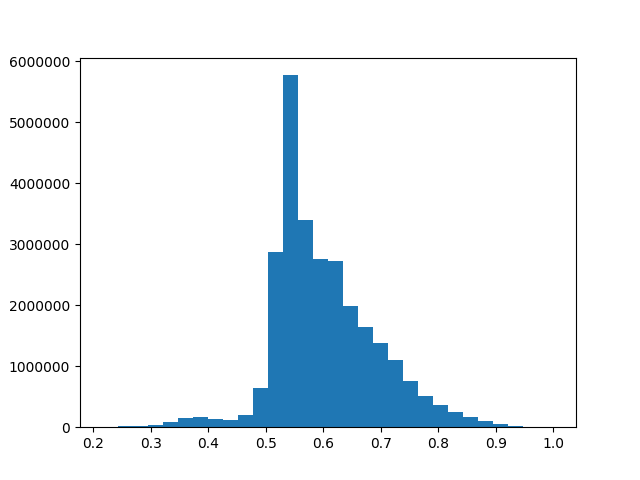

In [12]:
sims = fps_similarities([FingerprintMols.FingerprintMol(x) for x in list(all_mols[0])]+
                        [FingerprintMols.FingerprintMol(x) for x in list(all_mols[0])])
plt.close()
plt.hist(sims.flatten(),bins=30)
display(plt.show())

# MOSES Platform generative networks

In [14]:

from chemprop.parsing import parse_predict_args
from chemprop.train import make_predictions
from chemprop.parsing import add_predict_args
from chemprop.parsing import modify_predict_args
n_samples = '10000'

n_actives = 'class-vsjak2-neigh1x05-allseed-'#'regr-neigh1x05-allseed-'
#n_actives ='prob07-neighbors-allseed-'
coords_all = []
cols_all=[]
all_mols=[]
all_train_mols = []
nonjak_sizes = []
frame_sizes = []
all_sizes = []
nonjaks = []
reals_jak2 = []
def get_representatives(mols,cutoff):
  fps = get_fps(mols, bit=True)
  clusters=ClusterFps(fps, cutoff=cutoff)
  
  clu_rep_ids = [clu[0] for clu in clusters]
  return mols[clu_rep_ids], clu_rep_ids
targets = ['JAK1','JAK3','TYK2']#,'JAK2'
model = 'char_rnn'
for i, name in enumerate(targets):
  gen_save = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt-train'+'_vs'+name+'-iter'+str(9)+'x'+str(10)+'e50seedTest-'+n_actives+'actives-train-uniq.smi')
  #prediction
  preds_path_regression = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen'+n_samples+'_vs'+name+'-iter'+str(9)+'x'+str(10)+'e50seedTest-'+n_actives+'actives-preds-regression-train-uniq.csv')
               
  #checkpoint_path = os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/model.pt')
  checkpoint_dir = os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-2188-sparse-regression-scaffold')


  pred_parser = ArgumentParser()
  add_predict_args(pred_parser)
  args = pred_parser.parse_args(['--test_path',gen_save,
                                 #'--checkpoint_path',checkpoint_path,
                                 '--checkpoint_dir',checkpoint_dir,
                                 '--preds_path',preds_path_regression,
                                 #'--features_path',features_path,
                                ])
  modify_predict_args(args)
  #make_predictions(args)
  checkpoint_path = os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/model.pt')
 # checkpoint_dir = os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-2188-sparse-regression-scaffold')

  preds_path_classification = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen'+n_samples+'_vs'+name+'-iter'+str(9)+'x'+str(10)+'e50seedTest-'+n_actives+'actives-preds-classification-train-uniq.csv')
  pred_parser = ArgumentParser()
  add_predict_args(pred_parser)
  args = pred_parser.parse_args(['--test_path',gen_save,
                                 '--checkpoint_path',checkpoint_path,
                                 #'--checkpoint_dir',checkpoint_dir,
                                 '--preds_path',preds_path_classification,
                                 #'--features_path',features_path,
                                ])
  modify_predict_args(args)
  #make_predictions(args)
  frame = pd.read_csv(preds_path_regression)#pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt_gen'+n_samples+'_vs'+name+'-iter'+str(9)+'x'+str(10)+'e50seedTest-'+n_actives+'actives-preds-train-uniq.csv'))
  frame_sizes.append(len(frame))
  frame['Molecule'] = [Chem.MolFromSmiles(smi) for smi in frame.smiles]
  nonjak2 = pd.read_csv(preds_path_classification)#.dropna(subset=targets)
  nonjak2 = frame[nonjak2['JAK2']<0.05]
  X_train = pd.read_csv(os.path.join(VIRTUAL_SCREENING,name+'_actives.smi')).SMILES.tolist()
  #nonjak2 = nonjak2[~nonjak2.smiles.isin(X_train)]
  #nonjaks.append(nonjak2)
  
  
  
  #nonjak2 = nonjak2['Molecule'].tolist()
  
#   print(len(nonjak2))
  
  pl_frame = frame.dropna(subset=targets)
  if len(pl_frame)>3000:
    pl_frame = pl_frame.sample(3000)
  mols = np.array(pl_frame['Molecule'].tolist())
#   #mols,clu_rep_ids = get_representatives(mols,0.2)
#   #col = np.array(pl_frame[name].tolist())[clu_rep_ids]
  
#   train_mols = np.array([Chem.MolFromSmiles(smi) for smi in X_train])
#   all_bin = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all_2188-sparse-regression.csv'))
  
#   all_bin = all_bin[all_bin.smiles.isin(X_train)]
#   print(len(all_bin))
#   real_jak2 = [Chem.MolFromSmiles(smi) for smi in all_bin[all_bin['JAK2']>7.6].smiles]
#   #train_mols,clu_rep_ids = get_representatives(train_mols,0.2)
#   fps = get_fps(list(mols)+list(train_mols)+real_jak2+nonjak2['Molecule'].tolist(), bit=True)
#   dists = fps_distances(fps)
#   coords = get_embedding('tsne', 2, dists)
#   coords_all.append(coords)
#   all_mols.append(mols)
#   all_train_mols.append(train_mols)
#   reals_jak2.append(real_jak2)
  
  
  nonjak2['Molecule'] = [Chem.MolFromSmiles(smi) for smi in nonjak2.smiles]
  nonjak2['canonsmiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),canonical=True,isomericSmiles=False) for smi in nonjak2.smiles]
  all_trues = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all_2188-sparse-regression.csv'))
  all_trues.smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi.split('.')[0]),canonical=True,isomericSmiles=False) for smi in all_trues.smiles]
  true_actives = all_trues[all_trues[targets[i]]>7.6]#pd.read_csv(os.path.join(VIRTUAL_SCREENING,targets[j]+'_actives.smi')).SMILES.tolist()
  all_trues['Molecule'] = [Chem.MolFromSmiles(smi) for smi in all_trues.smiles]
  nonjak2 = nonjak2[~nonjak2.canonsmiles.isin(all_trues.smiles.tolist())]


  real_jak2 = [Chem.MolFromSmiles(smi) for smi in true_actives[true_actives['JAK2']>7.6].smiles]
  true_mols =[Chem.MolFromSmiles(smi) for smi in true_actives.smiles]
  print(len(nonjak2))
  #col = np.array(nonjak2[targets[j]].tolist())
  #true_mols = [Chem.MolFromSmiles(smi) for smi in train_mols]
#  mols = all_actives['Molecule'].tolist()
  #fps = get_fps(mols+true_mols+nonjak2['Molecule'].tolist(), bit=True)
  
  all_mols.append(mols)
  all_train_mols.append(true_mols)
  #cols_all.append(col)
 #all_sizes.append(sizes)
  nonjak_sizes.append(len(nonjak2))

  if len(nonjak2)>3000:
    nonjak2plot = nonjak2.sample(3000)
  nonjaks.append(nonjak2)
  col = np.array(nonjak2plot[name].tolist())
  cols_all.append(col)
  reals_jak2.append(real_jak2)
  fps = get_fps(list(mols)+true_mols+real_jak2+nonjak2plot['Molecule'].tolist(), bit=True)
  dists = fps_distances(fps)
  coords = get_embedding('tsne', 2, dists)
  coords_all.append(coords)

/local_disk0/tmp/1567354603719-0/PythonShell.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 self.stream = stream
/local_disk0/tmp/1567354603719-0/PythonShell.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 self._first_part = ''
3726
Errors in conversion: 0
Selected transformation: T-SNE
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7705 samples in 0.043s...
[t-SNE] Computed neighbors for 7705 samples in 0.750s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7705
[t-SNE] Computed conditional probabilities for sample 2000 / 7705
[t-SNE] Computed conditional probabilities for sample 3000 / 7705
[t-SNE] Computed conditional probabilities for sample 4000 / 7705
[t-SNE] Computed conditional probabilities for sample 5000 / 7705
[t-SNE] Computed conditional probabilities for sample 6000 / 7705
[t-SNE] Computed conditional probabilities for sample 7000 / 7705
[t-SNE] Computed conditional probabilities for sample 7705 / 7705
[t-SNE] Mean sigma: 0.249852
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.880257
[t-SNE] Error after 300 iterations: 2.245080
3023
Errors in conversion: 0
Selected transformation: T-SNE
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6602 samples in 0.030s...
[t-SNE] Computed neighbors for 6602 samples in 0.575s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6602
[t-SNE] Computed conditional probabilities for sample 2000 / 6602
[t-SNE] Computed conditional probabilities for sample 3000 / 6602
[t-SNE] Computed conditional probabilities for sample 4000 / 6602
[t-SNE] Computed conditional probabilities for sample 5000 / 6602
[t-SNE] Computed conditional probabilities for sample 6000 / 6602
[t-SNE] Computed conditional probabilities for sample 6602 / 6602
[t-SNE] Mean sigma: 0.247056
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.279144
[t-SNE] Error after 300 iterations: 1.883907
175
Errors in conversion: 0
Selected transformation: T-SNE
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3607 samples in 0.010s...
[t-SNE] Computed neighbors for 3607 samples in 0.166s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3607
[t-SNE] Computed conditional probabilities for sample 2000 / 3607
[t-SNE] Computed conditional probabilities for sample 3000 / 3607
[t-SNE] Computed conditional probabilities for sample 3607 / 3607
[t-SNE] Mean sigma: 0.238325
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.642090
[t-SNE] Error after 300 iterations: 1.343376

In [15]:
# All positive hits combined
len(set(sum([nj.canonsmiles.tolist() for nj in nonjaks],[])))

Out[21]: 26952

In [16]:
# JAK1
print(len(set(nonjaks[2].canonsmiles.tolist()+nonjaks[5].canonsmiles.tolist())))
jak1_vals = cols_all[2].tolist()+cols_all[5].tolist()
print(np.mean(jak1_vals))
print(np.min(jak1_vals))
print(np.max(jak1_vals))
print(np.median(jak1_vals))

21814
7.425371234475955
5.222857645930569
8.947100011088889
7.4728173847390575

In [17]:
# JAK3
print(len(set(nonjaks[3].canonsmiles.tolist()+nonjaks[6].canonsmiles.tolist())))
jak3_vals = cols_all[3].tolist()+cols_all[6].tolist()
print(np.mean(jak3_vals))
print(np.min(jak3_vals))
print(np.max(jak3_vals))
print(np.median(jak3_vals))

2861
6.760791555252521
4.553024880361013
8.367002605487878
6.811943593159393

In [18]:
# TYK2
print(len(set(nonjaks[4].canonsmiles.tolist()+nonjaks[7].canonsmiles.tolist())))
tyk2_vals = cols_all[4].tolist()+cols_all[7].tolist()
print(np.mean(tyk2_vals))
print(np.min(tyk2_vals))
print(np.max(tyk2_vals))
print(np.median(tyk2_vals))

2257
6.065800901177751
4.011078284127149
7.7873302341077
6.083818671531509

In [19]:
# JAK1 VJTNN

tyk2_vals = cols_all[0].tolist()
print(np.mean(tyk2_vals))
print(np.min(tyk2_vals))
print(np.max(tyk2_vals))
print(np.median(tyk2_vals))

7.56274784855488
7.028923308156831
8.38918563102646
7.552682418887948

In [20]:
# For appendix/representative drawing

from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.AllChem import CalcNumAtomStereoCenters
def get_clustering(mols,cutoff):
  fps = get_fps(mols, bit=True,size=6)
  clusters=ClusterFps(fps, cutoff=cutoff)
  return clusters
cutoff = 0.6
target_clusters = []
target_smarts = []
target_sizes = []

for nonjak in nonjaks:
  mols = np.array([Chem.MolFromSmiles(smi) for smi in nonjak.smiles])
  clusters = list(get_clustering(mols,cutoff))
  print(len(clusters))
  clusters.sort(key=len,reverse=True)
  if len(clusters)>50:
    clusters = clusters[:50]
  t_clu = []
  t_smrt = []
  t_s = []
  for cluster in clusters:
    cluster_mols = mols[list(cluster)]
    if len(cluster_mols)>1:
      
      mcs = FindMCS(cluster_mols, completeRingsOnly=False, ringMatchesRingOnly=False, matchValences=True, timeout=2)
      mcs = mcs.smartsString
      t_smrt.append(mcs)
      print(mcs)
      print(Chem.MolToSmiles(cluster_mols[0]))
      print('cluster size:',len(cluster_mols))
      t_clu.append(cluster_mols[0])
      t_s.append(len(cluster_mols))
  target_clusters.append(t_clu)
  target_smarts.append(t_smrt)
  target_sizes.append(t_s)

Errors in conversion: 0
16
[#6]-[#6]-[#7](-[#6])-[#16](=[#8])(=[#8])-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-12-[#6]-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2
CC(=O)NCC(=O)N1CCCC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
cluster size: 10
[#6]-[#6]-[#6]-[#6]-[#6]-[#8]-[#6](=[#8])-[#7]1-[#6]2-[#6]-[#6]-[#6]-1-[#6]-[#7](-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2
NS(=O)(=O)N1CCC[C@@H]1COC(=O)N1[C@H]2CC[C@@H]1CN(c1ncnc3[nH]ccc13)C2
cluster size: 5
[#6]-[#6]-[#7](-[#6]-[#6])-[#16](=[#8])(=[#8])-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-12-[#6]-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2
O=S(=O)(N(CCc1ccccc1)CCC(F)(F)F)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
cluster size: 2
[#8]=[#6](-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1):[#6]:[#6])-[#7]1-[#6]2-[#6]-[#6]-[#6]-1-[#6]-[#7](-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2
O=C(c1ccc2sccc2c1)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2
cluster size: 2
Errors in conversion: 0
1

In [21]:
# For appendix
for i in range(len(target_clusters)):
  print([Chem.MolToSmiles(smi) for smi in target_clusters[i]])
  print('\n')
  print(target_smarts[i])
  print('\n')
  print(target_sizes[i])
  
  print('\n')

['CC(=O)NCC(=O)N1CCCC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2', 'NS(=O)(=O)N1CCC[C@@H]1COC(=O)N1[C@H]2CC[C@@H]1CN(c1ncnc3[nH]ccc13)C2', 'O=S(=O)(N(CCc1ccccc1)CCC(F)(F)F)N1CCN(c2ncnc3[nH]ccc23)CC12CC2', 'O=C(c1ccc2sccc2c1)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2']


['[#6]-[#6]-[#7](-[#6])-[#16](=[#8])(=[#8])-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-12-[#6]-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2', '[#6]-[#6]-[#6]-[#6]-[#6]-[#8]-[#6](=[#8])-[#7]1-[#6]2-[#6]-[#6]-[#6]-1-[#6]-[#7](-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2', '[#6]-[#6]-[#7](-[#6]-[#6])-[#16](=[#8])(=[#8])-[#7]1-[#6]-[#6]-[#7](-[#6]-[#6]-12-[#6]-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2', '[#8]=[#6](-[#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1):[#6]:[#6])-[#7]1-[#6]2-[#6]-[#6]-[#6]-1-[#6]-[#7](-[#6]-2)-[#6]1:[#7]:[#6]:[#7]:[#6]2:[#6]:1:[#6]:[#6]:[#7]:2']


[10, 5, 2, 2]


[]


[]


[]

In [22]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.AllChem import CalcNumAtomStereoCenters
from rdkit.DataStructs.TopNContainer import TopNContainer

def get_clu_ids(mols,cutoff):
  fps = get_fps(mols, bit=True,size=6)
  clusters=ClusterFps(fps, cutoff=cutoff)
  return clusters
cutoff = 0.6
real_smiles = np.array(all_trues.smiles)
targets = ['JAK1','JAK3','TYK2']
for i, nonjak in enumerate(nonjaks):
  mols = np.array([Chem.MolFromSmiles(smi) for smi in nonjak.smiles])
  clusters = list(get_clu_ids(mols,cutoff))
  
  print(targets[i])
  
  clusters.sort(key=len,reverse=True)
  for cluster in clusters[:2]:
    clu_df = nonjak.iloc[list(cluster)]
    max_row = clu_df.loc[clu_df[targets[i]].idxmax()]
    nearest_real_id = np.argmax(np.array(DataStructs.BulkTanimotoSimilarity(FingerprintMols.FingerprintMol(max_row['Molecule']),[FingerprintMols.FingerprintMol(x) for x in all_trues['Molecule']],returnDistance=False)))
    nearest_real = all_trues.iloc[nearest_real_id]#real_smiles[nearest_real_id]
    print('Best clu : ',max_row.smiles)
    print('Activity : ',max_row[targets[i]])
    print('Best real: ',nearest_real.smiles)
    print('Activity : ',nearest_real[targets[i]])
  for j, row in nonjak.nlargest(2, columns=[targets[i]]).iterrows():
    max_row = row
    nearest_real_id = np.argmax(np.array(DataStructs.BulkTanimotoSimilarity(FingerprintMols.FingerprintMol(max_row['Molecule']),[FingerprintMols.FingerprintMol(x) for x in all_trues['Molecule']],returnDistance=False)))
    nearest_real = all_trues.iloc[nearest_real_id]
    print('Best mol : ',max_row.smiles)
    print('Activity : ',max_row[targets[i]])
    print('Best real: ',nearest_real.smiles)
    print('Activity : ',nearest_real[targets[i]])

Errors in conversion: 0
JAK1
Best clu : O=S(=O)(NC(=O)[C@H]1CCN(c2ncnc3[nH]ccc23)CC12CC2)c1ccccc1
Activity : 8.968547886202154
Best real: NS(=O)(=O)c1ccc(CNC(=O)C2CCN(c3ncnc4[nH]ccc34)CC23CC3)cc1
Activity : 8.728158393463499
Best clu : NC(=C[C@H]1CC[C@@H]1COC(=O)[C@H]1CCN(c2ncnc3[nH]ccc23)CC12CC2)[C@@H](O)C1CCCCC1
Activity : 8.961130997093546
Best real: O=C(OCCC1CCCCC1)C1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 7.132532512140949
Best mol : CN(CC(N)C(=O)NS(=O)(=O)NC(=O)OCC(=O)OC1CC(F)(F)C1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 9.232662066879977
Best real: CC(C)(C)OC(=O)NS(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 7.298432014944072
Best mol : CCCN(CC(=O)NS(=O)(=O)NC(=O)[C@H]1CC(F)(F)C1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 9.152545109026876
Best real: CN(CC1CC(F)(F)C1)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 9.096910013008056
Errors in conversion: 0
JAK3
Best clu : OC(=CN1CC(F)(F)CN1S(=O)(=O)NC(=O)OC(=O)OC(=O)OC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 7.886372863405201
Best real: CCC(C#N)S(=O)(=O)N1CC(F)(F)CC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 7.667561540084394
Best clu : O=C[C@H]1CC[C@@H]([C@@H](O)CNC(=O)[C@H]2CCN(c3ncnc4[nH]ccc34)CC23CC3)C1
Activity : 7.846130830140558
Best real: O=C(NCC(O)C1CCCC1)C1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 8.486782399932059
Best mol : NS(=O)(=O)CC(=O)N1CCN(c2ncnc3ccccc23)CC12CC2
Activity : 7.9462651599187994
Best real: NS(=O)(=O)CC(=O)N1C2CCC1CN(c1ncnc3[nH]ccc13)C2
Activity : 6.5951662833800615
Best mol : OC(=CN1CC(F)(F)CN1S(=O)(=O)NC(=O)OC(=O)OC(=O)OC(=O)O)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 7.886372863405201
Best real: CCC(C#N)S(=O)(=O)N1CC(F)(F)CC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 7.667561540084394
Errors in conversion: 0
TYK2
Best clu : CCOCC1(CO)CCC[C@H]1C(=O)NC(=O)N1CC(F)(F)C[C@@H]1CN(C)S(=O)(=O)N1C[C@@H](C)N(c2ncnc3[nH]ccc23)CC12CC2
Activity : 7.712148144776808
Best real: CN1CCN(C(=O)N2CC(F)(F)CC2CN(C)S(=O)(=O)N2CCN(c3ncnc4[nH]ccc34)CC23CC3)CC1
Activity : 6.366531544420414
Best clu : O=CCC(=O)NS(=O)(=O)N1CC(F)(F)C[C@H]1C(=O)Nc1ncnc2[nH]ccc12
Activity : 6.9496875229815815
Best real: CC(C)CC(=O)NS(=O)(=O)N1CC(F)(F)CC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 7.301029995663981
Best mol : CC(=O)NC(=O)NC(=O)N1CC(F)(F)C[C@@H]1CN(C)S(=O)(=O)N1CC(F)(F)C[C@H]1C(=O)Nc1ccc(F)c([O-])c1
Activity : 7.777951108102461
Best real: CNC(=O)N1CC(F)(F)CC1CN(C)S(=O)(=O)N1CCN(c2ncnc3[nH]ccc23)CC12CC2
Activity : 7.595166283380062
Best mol : CCOCC1(CO)CCC[C@H]1C(=O)NC(=O)N1CC(F)(F)C[C@@H]1CN(C)S(=O)(=O)N1C[C@@H](C)N(c2ncnc3[nH]ccc23)CC12CC2
Activity : 7.712148144776808
Best real: CN1CCN(C(=O)N2CC(F)(F)CC2CN(C)S(=O)(=O)N2CCN(c3ncnc4[nH]ccc34)CC23CC3)CC1
Activity : 6.366531544420414

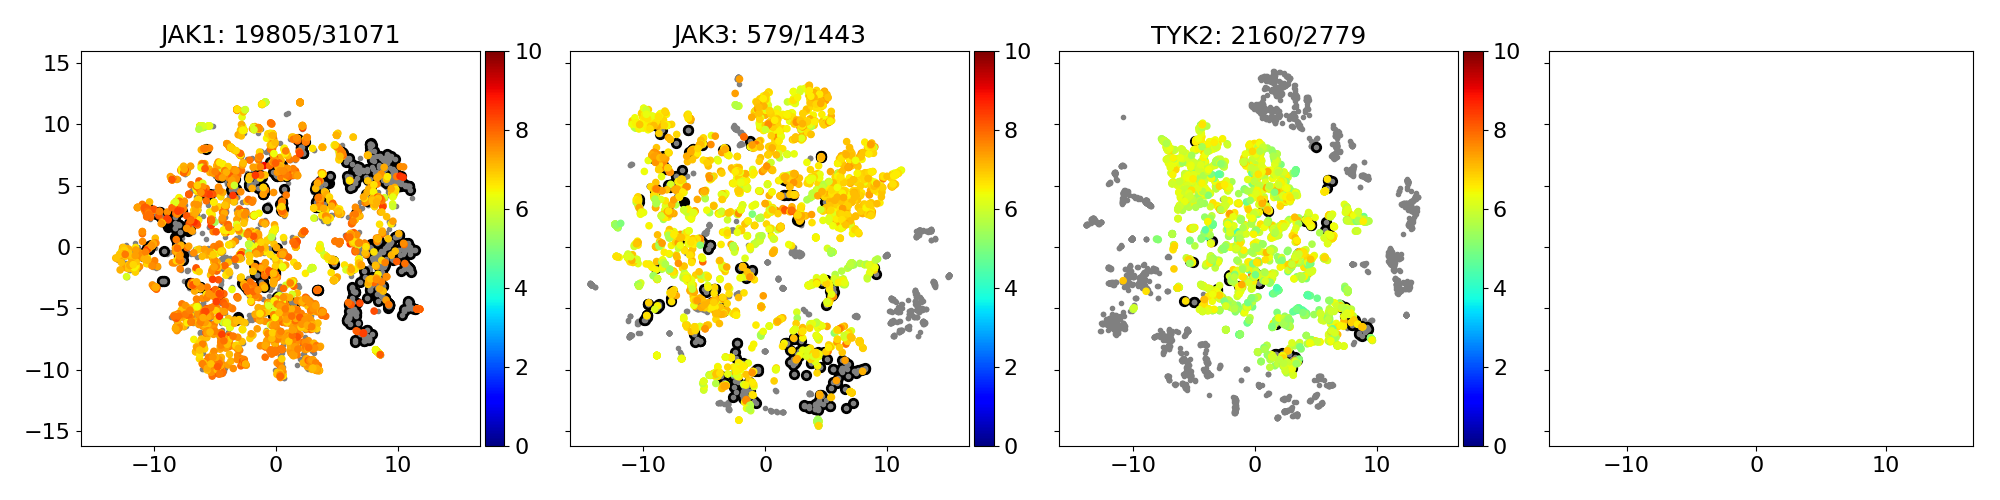

In [23]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.close()
f, axes = plt.subplots(1, 4, sharex = True, sharey=True, figsize=(20,5))

for i, name in enumerate(targets):
  
  axes[i].scatter(coords_all[i][:len(all_mols[i]), 0], 
                   coords_all[i][:len(all_mols[i]), 1], 
                   marker = '.',c='grey'#,s=200, facecolors='none', edgecolors='grey'
                )
  axes[i].scatter(coords_all[i][len(all_mols[i]):len(all_mols[i])+len(all_train_mols[i]), 0], 
                   coords_all[i][len(all_mols[i]):len(all_mols[i])+len(all_train_mols[i]), 1], 
                   marker = '.',c='k',s=200, #facecolors='none', edgecolors='grey'
                )
  axes[i].scatter(coords_all[i][len(all_mols[i])+len(all_train_mols[i]):len(all_mols[i])+len(reals_jak2[i])+len(all_train_mols[i]), 0], 
                   coords_all[i][len(all_mols[i])+len(all_train_mols[i]):len(all_mols[i])+len(reals_jak2[i])+len(all_train_mols[i]), 1], 
                   marker = '.',c='grey'#,s=200, facecolors='none', edgecolors='grey'
                )
  f, ax, sc = plot_transformation_2D(coords_all[i][len(all_mols[i])+len(reals_jak2[i])+len(all_train_mols[i]):, ],#coords_all[i][:len(all_mols[i]), ],
                                   coloring=cols_all[i],
                                   figure=(f, axes[i]),
                                   color_correction=(0,10),marker='.',s=80)
  ax.set_title(str(name)+': '+str(nonjak_sizes[i])+'/'+str(frame_sizes[i]), fontsize=18)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)

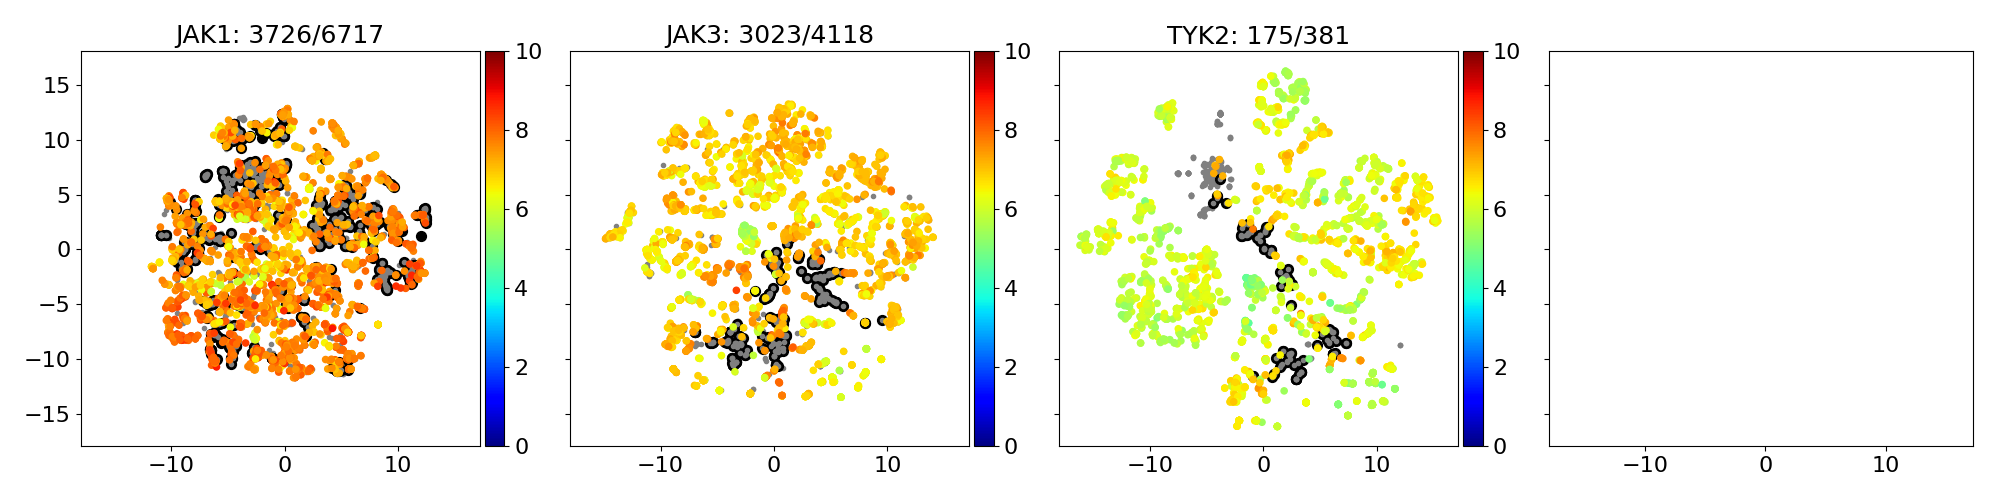

In [24]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.close()
f, axes = plt.subplots(1, 4, sharex = True, sharey=True, figsize=(20,5))

for i, name in enumerate(targets):
  
  axes[i].scatter(coords_all[i][:len(all_mols[i]), 0], 
                   coords_all[i][:len(all_mols[i]), 1], 
                   marker = '.',c='grey'#,s=200, facecolors='none', edgecolors='grey'
                )
  axes[i].scatter(coords_all[i][len(all_mols[i]):len(all_mols[i])+len(all_train_mols[i]), 0], 
                   coords_all[i][len(all_mols[i]):len(all_mols[i])+len(all_train_mols[i]), 1], 
                   marker = '.',c='k',s=200, #facecolors='none', edgecolors='grey'
                )
  axes[i].scatter(coords_all[i][len(all_mols[i])+len(all_train_mols[i]):len(all_mols[i])+len(reals_jak2[i])+len(all_train_mols[i]), 0], 
                   coords_all[i][len(all_mols[i])+len(all_train_mols[i]):len(all_mols[i])+len(reals_jak2[i])+len(all_train_mols[i]), 1], 
                   marker = '.',c='grey'#,s=200, facecolors='none', edgecolors='grey'
                )
  f, ax, sc = plot_transformation_2D(coords_all[i][len(all_mols[i])+len(reals_jak2[i])+len(all_train_mols[i]):, ],#coords_all[i][:len(all_mols[i]), ],
                                   coloring=cols_all[i],
                                   figure=(f, axes[i]),
                                   color_correction=(0,10),marker='.',s=80)
  ax.set_title(str(name)+': '+str(nonjak_sizes[i])+'/'+str(frame_sizes[i]), fontsize=18)
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  f.colorbar(sc, cax=cax)

f.tight_layout()
display(f)